# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import psycopg2, pandas as pd
from sql_queries import airportCodes_insert, demographic_insert, immigration_insert, temperature_insert

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

In [2]:
# Read in the data here
airportCodes = pd.read_csv('airport-codes_csv.csv')
immi = pd.read_csv('immigration_data_sample.csv')
demo = pd.read_csv('us-cities-demographics.csv', sep = ";")
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
#immiMain = pd.read_sas(fname, 'sas7bdat', encoding="ISO-8859-1")
tname = '../../data2/GlobalLandTemperaturesByCity.csv'
temp = pd.read_csv(tname)

In [3]:
airportCodes.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [4]:
percent_missing = airportCodes.isnull().sum() * 100 / len(airportCodes)
missing_value_airport = pd.DataFrame({'column_name': airportCodes.columns,
                                 'percent_missing': percent_missing})
missing_value_airport

,column_name,percent_missing
ident,ident,0.000000
type,type,0.000000
name,name,0.000000
elevation_ft,elevation_ft,12.720835
continent,continent,50.329551
iso_country,iso_country,0.448479
iso_region,iso_region,0.000000
municipality,municipality,10.305946
gps_code,gps_code,25.501589
iata_code,iata_code,83.315479


In [5]:
#browse immigration
immi.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [6]:
immi.shape

(1000, 29)

In [7]:
#investigate if admission number can be used as unique primary index
immi['admnum'].nunique()
# from tha sample data it looks like the field admnum can be used as primary index for an immigaration fact table

1000

In [8]:
# find fields with large number of missing values in imigration data

percent_missing = immi.isnull().sum() * 100 / len(immi)
missing_value_immi = pd.DataFrame({'column_name': immi.columns,
                                 'percent_missing': percent_missing})
missing_value_immi

#visapost, occup,entdepu, isnum all have large amount of missing data (>50%)

,column_name,percent_missing
Unnamed: 0,Unnamed: 0,0.0
cicid,cicid,0.0
i94yr,i94yr,0.0
i94mon,i94mon,0.0
i94cit,i94cit,0.0
i94res,i94res,0.0
i94port,i94port,0.0
arrdate,arrdate,0.0
i94mode,i94mode,0.0
i94addr,i94addr,5.9


In [9]:
#browse airport codes data
airportCodes.head(5)


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [10]:
#explore ident as primary unique identifier
airportCodes['ident'].nunique()

55075

In [11]:
airportCodes.shape

(55075, 12)

In [12]:
#explore missing values in airport codes data
#iata code, continent and local code hve large number of missing values (~50%)

percent_missing = airportCodes.isnull().sum() * 100 / len(airportCodes)
missing_value_air = pd.DataFrame({'column_name': airportCodes.columns,
                                 'percent_missing': percent_missing})
missing_value_air

,column_name,percent_missing
ident,ident,0.000000
type,type,0.000000
name,name,0.000000
elevation_ft,elevation_ft,12.720835
continent,continent,50.329551
iso_country,iso_country,0.448479
iso_region,iso_region,0.000000
municipality,municipality,10.305946
gps_code,gps_code,25.501589
iata_code,iata_code,83.315479


In [13]:
#browse temperature data
temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [14]:
#explore missing values in temperature data
#include all fields in temperature since very few records are nulls/empty

percent_missing = temp.isnull().sum()*100 /len(temp)
missing_value_temp = pd.DataFrame({'column_name': temp.columns,
                                 'percent_missing': percent_missing})
missing_value_temp

,column_name,percent_missing
dt,dt,0.000000
AverageTemperature,AverageTemperature,4.234458
AverageTemperatureUncertainty,AverageTemperatureUncertainty,4.234458
City,City,0.000000
Country,Country,0.000000
Latitude,Latitude,0.000000
Longitude,Longitude,0.000000


In [15]:
#browse demographics data
demo.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [16]:
# is each row a unique city?
demo['City'].nunique()

567

In [17]:
demo.shape

(2891, 12)

In [18]:
# explore missing values for fields in demographics data
percent_missing = demo.isnull().sum() * 100 / len(demo)
missing_value_demo = pd.DataFrame({'column_name': demo.columns,
                                 'percent_missing': percent_missing})
missing_value_demo

,column_name,percent_missing
City,City,0.000000
State,State,0.000000
Median Age,Median Age,0.000000
Male Population,Male Population,0.103770
Female Population,Female Population,0.103770
Total Population,Total Population,0.000000
Number of Veterans,Number of Veterans,0.449671
Foreign-born,Foreign-born,0.449671
Average Household Size,Average Household Size,0.553442
State Code,State Code,0.000000


In [19]:
#number of veterans, foreign born, and Av Household size are missing a large % of values

The below section in green is optional and can be used in case of an increase of write ups. Makes use of pyspark.

In [20]:
# the pyspark section can be used in case of a sudden increase in usage (100 factor)
# only added here as an alternative
# for this excersice and due to timing constraints, only csv approach is used

#from pyspark.sql import SparkSession
#spark = SparkSession.builder.\
#config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
#.enableHiveSupport().getOrCreate()
#immiMain =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [21]:
#immiMain.limit(10).toPandas()

In [22]:
#immiMain.write.mode("overwrite").parquet("immigration_data")

In [23]:
#print((immiMain.count(), len(immiMain.columns)))

In [24]:
#immiMain = immiMain.dropDuplicates()

In [25]:
#from pyspark.sql.functions import isnan, when, count, col
#immid = immiMain.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in immiMain.columns])

In [26]:
#immipd = immid.toPandas()

In [27]:
#immiMis = immipd.loc[:,immipd.gt(1000).any()]
#immiMis/immiMain.count() 

In [28]:
#import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('ggplot')
#x = list(immiMis.columns)
#x_pos = [i for i, _ in enumerate(x)]
#y = list(immiMis.iloc[0])
#plt.bar(x_pos,y)
#plt.show()

In [29]:
#immipd.columns

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [30]:
#from all tables, remove fields with 50% + missing values. This is done at create and insert records steps.

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

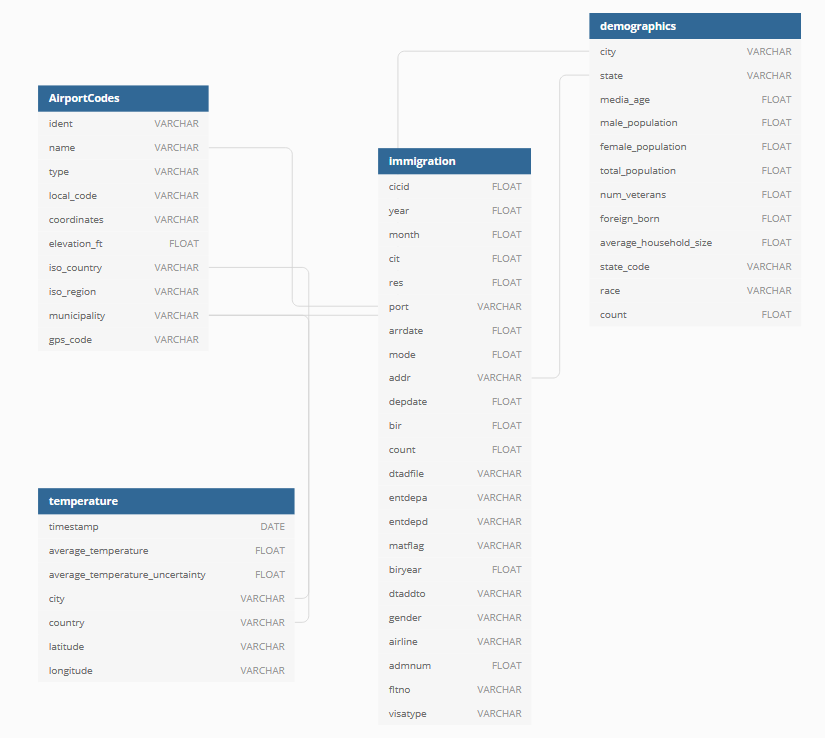

In [31]:
from IPython.display import Image
Image(filename='DBdiagram.PNG')

# based on the data exploration above, the tables will be as follows:

|Table Name||Fields||type|
|-----||----||----|
|AirportCodes||ident, name, "type",local_code,coordinated,elevation_ft,iso_country,iso_region, municipality, gps_code||Dimension|
|demographics||city, state, median_age, male_population, female_population, total_population, num_veterans, foreign_born, average_household_size, state_code, race, count||Dimension|
|immigration||cicid, year, month, cit, res, arrdate,port ,mode,addr,depdate, bir,count, dtadfile, entdepa, entdepd,matflag, biryear,dtaddto,gender, airline, admnum, fltno, visatype||Fact|
|temperature||timestamp, average_temperature,average_temperature_uncertainty, city, country, latitude, longitude||Dimension|

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [33]:
# create_tables.py has been run. insert the data into the database
conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=student password=student")
cur = conn.cursor()


In [34]:
# first select airport relevant fields
ins_airport = airportCodes[['ident','name','type','local_code','coordinates','elevation_ft','iso_country','iso_region','municipality','gps_code']]



In [35]:
for index, row in ins_airport.iterrows():
    cur.execute(airportCodes_insert, list(row.values))
    conn.commit()

In [36]:
# load all demographic fields into table 
for index, row in demo.iterrows():
    cur.execute(demographic_insert, list(row.values))
    conn.commit()

In [37]:
#select relevant fields for immigration table
ins_immi = immi[['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port',
       'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir',
       'count', 'dtadfile', 'entdepa', 'entdepd',
        'matflag', 'biryear', 'dtaddto', 'gender',
       'airline', 'admnum', 'fltno', 'visatype']]

In [38]:
#insert relevant fields/records into immigration table
for index, row in ins_immi.iterrows():
    cur.execute(immigration_insert, list(row.values))
    conn.commit()

In [39]:
#insert relevant fields/records into tempaerature table
# tFor the sake of this excersise a sample is taken in order to speed up work

temp = temp.sample(1000)
for index, row in temp.iterrows():
    cur.execute(temperature_insert, list(row.values))
    conn.commit()

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [58]:
# Perform quality checks here
# make sure that tables have records

cur.execute("SELECT COUNT(*) FROM airportCodes")
conn.commit()
if cur.rowcount < 1:
    print("No records in table airportCodes")
else:
    print('Records successfully inserted in AirportCodes table')
    print(cur.fetchall()[0][0])



Records successfully inserted in AirportCodes table
55075


In [60]:
cur.execute("SELECT COUNT(*) FROM demographics")
conn.commit()
if cur.rowcount < 1:
    print("No records in table demographics")
else:
    print('Records successfully inserted in demographics table')
    print(cur.fetchall()[0][0])


Records successfully inserted in demographics table
2891


In [61]:
cur.execute("SELECT COUNT(*) FROM immigration")
conn.commit()
if cur.rowcount < 1:
    print("No records in table immigration")
else:
    print('Records successfully inserted in immigration table')
    print(cur.fetchall()[0][0])


Records successfully inserted in immigration table
1000


In [62]:
cur.execute("SELECT COUNT(*) FROM temperature")
conn.commit()
if cur.rowcount < 1:
    print("No records in table temperature")
else:
    print('Records successfully inserted in temperature table')
    print(cur.fetchall()[0][0])


Records successfully inserted in temperature table
1000


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.


|Fact Immigration Table||Description|
|----------||-----------------|
|cicid||Unique record ID|
|year||4 digit year|
|month||Numeric month|
|cit||3 digit code for immigrant country of birth|
|res||3 digit code for immigrant country of residence|
|port||Port of admission|
|arrdate||Arrival Date in the USA|
|mode||Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)|
|addr||USA State of arrival|
|depdate||Departure Date from the USA|
|bir||Age of Respondent in Years|
|count||Field used for summary statistics|
|dtadfile||Character Date Field - Date added to I-94 Files|
|entdepa||Arrival Flag - admitted or paroled into the U.S.|
|entdepd||Departure Flag - Departed, lost I-94 or is deceased|
|matflag||Match flag - Match of arrival and departure records|
|biryear||4 digit year of birth|
|dtaddto||Character Date Field - Date to which admitted to U.S. (allowed to stay until)|
|gender||Non-immigrant sex|
|airline||Airline used to arrive in U.S.|
|admnum||Admission Number|
|fltno||Flight number of Airline used to arrive in U.S.|
|visatype||Class of admission legally admitting the non-immigrant to temporarily stay in U.S.|





|Dim AirportCodes Table||Description|
|----------||-----------------|
|ident||ID|
|name||Airport Name|
|type||type of airport|
|local_code||local code of airport|
|coordinates||latitude and longitude of airport|
|elevation_ft||elevation above sea level of airport measured in feet|
|iso_country||iso country code of country locatin of airport|
|iso_region||iso region code of country locatin of airport|
|municipality||city or municipality of airport|
|gps_code||gps code of airport location|



|Dim Temperature Table||Description|
|----------||-----------------|
|Timestamp||Timestamp of temperature taken at time|
|average_temperature||average temparature for the period|
|average_temperature_uncertainty||average temperature uncertainty for the period|
|city||city of measured temperature|
|country||country of measured temperature|
|latitude||latitude of measured temperature|
|longitude||longitude of measured temperature|



|Dim Demographics Table||Description|
|----------||-----------------|
|city||city|
|state||state|
|median_age||median age of population|
|male_population||count of male population|
|total population||total population|
|female_population||count of female population|
|num_veterans||count of veterans in population|
|foreign born||count of people born overseas|
|average_household_size||average number of people household|
|state||state|
|state_code||state code|
|race||race|
|count||count|

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.